# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = '/data'
!pip install matplotlib==2.0.2
# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

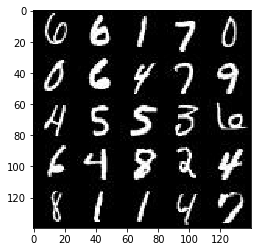

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

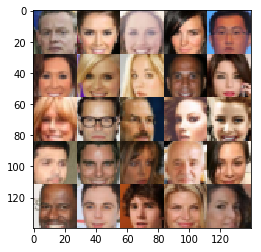

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.3.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    inputs_real = tf.placeholder(tf.float32, shape=(None, image_width, image_height, image_channels), name='input_real')
    inputs_z = tf.placeholder(tf.float32, shape=(None, z_dim), name='input_z')
    learning_rate = tf.placeholder(tf.float32, shape=(), name='learning_rate')

    return inputs_real, inputs_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def discriminator(images, reuse=False, alpha=0.1, kernel_size=5, keep_prob=0.9):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :param alpha: Leak factor that sets the magnitude of the output for negative values.
    :param kernel_size: Refers to the widthxheight of the filter mask. 
    :param keep_prob: 1- The probability that each element of x is discarded. 
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    
    with tf.variable_scope('discriminator', reuse=reuse):
        # Input layer is 28x28x3
        x1 = tf.layers.conv2d(images, 32, kernel_size, strides=2, padding='same')
        relu1 = tf.maximum(alpha * x1, x1)
        drop1 = tf.nn.dropout(relu1, keep_prob=keep_prob)
        # 14x14x32
        
        x2 = tf.layers.conv2d(drop1, 64, kernel_size, strides=2, padding='same')
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(alpha * bn2, bn2)
        drop2 = tf.nn.dropout(relu2, keep_prob=keep_prob)
        # 7x7x64

        x3 = tf.layers.conv2d(drop2, 128, kernel_size, strides=2, padding='same', activation=None)
        bn3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = tf.maximum(alpha * bn3, bn3)
        drop3 = tf.nn.dropout(relu3, keep_prob=keep_prob)
        # 4x4x128
        
        # Flatten it
        flat = tf.reshape(drop3, (-1, 4*4*128))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
        
        return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True, alpha=0.1, kernel_size=5, keep_prob=0.9):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image (28x28x3)
    :param is_train: Boolean if generator is being used for training
    :param alpha: Leak factor that sets the magnitude of the output for negative values.
    :param kernel_size: Refers to the widthxheight of the filter mask. 
    :return: The tensor output of the generator
    """
    with tf.variable_scope('generator', reuse=not(is_train)):
        
        # First fully connected layer
        x0 = tf.layers.dense(z, 7*7*254)
        # Reshape it to start the convolutional stack
        x1 = tf.reshape(x0, (-1, 7, 7, 254))
        bn1 = tf.layers.batch_normalization(x1, training=is_train)
        relu1 = tf.maximum(alpha * bn1, bn1)
        drop1 = tf.nn.dropout(relu1, keep_prob=keep_prob)
        # 7x7x254 now
        
        x2 = tf.layers.conv2d_transpose(drop1, 128, kernel_size, strides=2, padding='same')
        bn2 = tf.layers.batch_normalization(x2, training=is_train)
        relu2 = tf.maximum(alpha * bn2, bn2)
        drop2 = tf.nn.dropout(relu2, keep_prob=keep_prob)
        # 14x14x128 now
        
        x3 = tf.layers.conv2d_transpose(drop2, 64, kernel_size, strides=2, padding='same')
        bn3 = tf.layers.batch_normalization(x3, training=is_train)
        relu3 = tf.maximum(alpha * bn3, bn3)
        drop3 = tf.nn.dropout(relu3, keep_prob=keep_prob)
        # 28x28x64 now
        
        x4 = tf.layers.conv2d_transpose(drop3, 32, kernel_size, strides=1, padding='same')
        bn4 = tf.layers.batch_normalization(x4, training=is_train)
        relu4 = tf.maximum(alpha * bn4, bn4)
        drop4 = tf.nn.dropout(relu4, keep_prob=keep_prob)
        # 28x28x32 now
        
        # Output layer
        logits = tf.layers.conv2d_transpose(drop4, out_channel_dim, kernel_size, strides=1, padding='same')
        # 28x28x3 now
        
        out = tf.tanh(logits)
        
        return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim, alpha=0.1):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :param alpha: Leak factor that sets the magnitude of the output for negative values.
    :return: A tuple of (discriminator loss, generator loss)
    """
    g_model = generator(input_z, out_channel_dim, alpha=alpha)
    d_model_real, d_logits_real = discriminator(input_real, alpha=alpha)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True, alpha=alpha)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake

    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [11]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode, print_every=10, show_every=100):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data [rows, image_width, image_height, image_channels]
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    input_real, input_z, lr = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, data_shape[3])
    d_opt, g_opt = model_opt(d_loss, g_loss, lr, beta1)   
    
    samples, losses = [], []
    steps = 0
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                steps += 1
                # scales images to (-1: 1) from (-.5:.5) 
                batch_images *= 2
                
                # Sample random noise for Generator
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                # Run optimizers
                _ = sess.run(d_opt, feed_dict={input_z: batch_z, input_real: batch_images, lr: learning_rate})
                _ = sess.run(g_opt, feed_dict={input_z: batch_z, input_real: batch_images, lr: learning_rate})
                
                # Visual progress
                if steps % print_every == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    # Save losses to view after training
                    losses.append((train_loss_d, train_loss_g))
                    
                if steps % show_every == 0:
                    # show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode)
                    show_generator_output(sess, 25, input_z, data_shape[3], data_image_mode)
    
        # Final plot
        print('Final Plot')
        show_generator_output(sess, 25, input_z, data_shape[3], data_image_mode)

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 1.8076... Generator Loss: 0.3762
Epoch 1/2... Discriminator Loss: 1.6091... Generator Loss: 0.7437
Epoch 1/2... Discriminator Loss: 1.4086... Generator Loss: 1.4417
Epoch 1/2... Discriminator Loss: 1.4890... Generator Loss: 0.6191
Epoch 1/2... Discriminator Loss: 1.8020... Generator Loss: 0.9150
Epoch 1/2... Discriminator Loss: 1.4306... Generator Loss: 0.8743
Epoch 1/2... Discriminator Loss: 1.2081... Generator Loss: 1.0073
Epoch 1/2... Discriminator Loss: 1.2928... Generator Loss: 1.0793
Epoch 1/2... Discriminator Loss: 1.3100... Generator Loss: 0.8149
Epoch 1/2... Discriminator Loss: 1.2202... Generator Loss: 0.6624


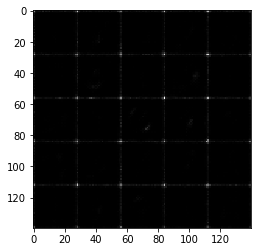

Epoch 1/2... Discriminator Loss: 1.2964... Generator Loss: 0.6793
Epoch 1/2... Discriminator Loss: 1.3289... Generator Loss: 0.7272
Epoch 1/2... Discriminator Loss: 1.5780... Generator Loss: 0.4074
Epoch 1/2... Discriminator Loss: 1.3784... Generator Loss: 0.5765
Epoch 1/2... Discriminator Loss: 1.2733... Generator Loss: 0.8482
Epoch 1/2... Discriminator Loss: 1.3923... Generator Loss: 0.7273
Epoch 1/2... Discriminator Loss: 1.4483... Generator Loss: 0.8301
Epoch 1/2... Discriminator Loss: 1.3926... Generator Loss: 0.9862
Epoch 1/2... Discriminator Loss: 1.4135... Generator Loss: 0.5611
Epoch 1/2... Discriminator Loss: 1.4238... Generator Loss: 0.5459


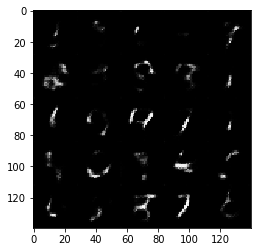

Epoch 1/2... Discriminator Loss: 1.3027... Generator Loss: 0.8376
Epoch 1/2... Discriminator Loss: 1.4524... Generator Loss: 0.4776
Epoch 1/2... Discriminator Loss: 1.2415... Generator Loss: 0.8621
Epoch 1/2... Discriminator Loss: 1.1810... Generator Loss: 0.7409
Epoch 1/2... Discriminator Loss: 1.5057... Generator Loss: 0.5461
Epoch 1/2... Discriminator Loss: 1.2013... Generator Loss: 1.0145
Epoch 1/2... Discriminator Loss: 1.2261... Generator Loss: 0.8627
Epoch 1/2... Discriminator Loss: 1.2763... Generator Loss: 0.8326
Epoch 1/2... Discriminator Loss: 1.2628... Generator Loss: 0.6368
Epoch 1/2... Discriminator Loss: 1.2781... Generator Loss: 0.9800


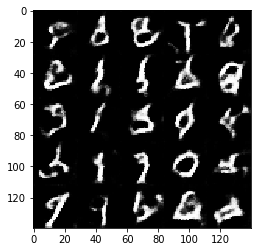

Epoch 1/2... Discriminator Loss: 1.4021... Generator Loss: 0.5586
Epoch 1/2... Discriminator Loss: 1.3558... Generator Loss: 0.7528
Epoch 1/2... Discriminator Loss: 1.3703... Generator Loss: 1.0905
Epoch 1/2... Discriminator Loss: 1.3595... Generator Loss: 0.8218
Epoch 1/2... Discriminator Loss: 1.3336... Generator Loss: 0.9560
Epoch 1/2... Discriminator Loss: 1.2937... Generator Loss: 0.6784
Epoch 1/2... Discriminator Loss: 1.2310... Generator Loss: 0.8920
Epoch 1/2... Discriminator Loss: 1.1554... Generator Loss: 0.9012
Epoch 1/2... Discriminator Loss: 1.2735... Generator Loss: 0.9961
Epoch 1/2... Discriminator Loss: 1.1858... Generator Loss: 0.7534


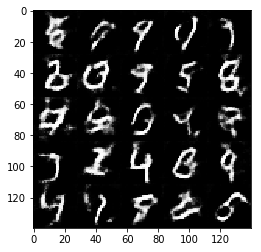

Epoch 1/2... Discriminator Loss: 1.2401... Generator Loss: 0.6809
Epoch 1/2... Discriminator Loss: 1.4851... Generator Loss: 0.5012
Epoch 1/2... Discriminator Loss: 1.1922... Generator Loss: 0.8578
Epoch 1/2... Discriminator Loss: 1.1968... Generator Loss: 0.5880
Epoch 1/2... Discriminator Loss: 1.3843... Generator Loss: 0.5532
Epoch 1/2... Discriminator Loss: 1.2309... Generator Loss: 0.6814
Epoch 1/2... Discriminator Loss: 1.3771... Generator Loss: 0.6137
Epoch 1/2... Discriminator Loss: 1.1683... Generator Loss: 0.5710
Epoch 1/2... Discriminator Loss: 1.2122... Generator Loss: 0.9251
Epoch 1/2... Discriminator Loss: 1.2750... Generator Loss: 0.7190


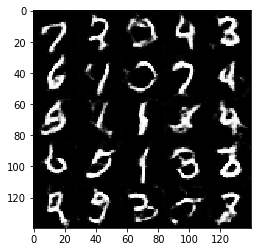

Epoch 1/2... Discriminator Loss: 1.1470... Generator Loss: 0.8386
Epoch 1/2... Discriminator Loss: 1.1345... Generator Loss: 0.9142
Epoch 1/2... Discriminator Loss: 1.2722... Generator Loss: 0.8252
Epoch 1/2... Discriminator Loss: 1.2576... Generator Loss: 0.9873
Epoch 1/2... Discriminator Loss: 1.2951... Generator Loss: 0.6996
Epoch 1/2... Discriminator Loss: 1.4152... Generator Loss: 0.4727
Epoch 1/2... Discriminator Loss: 1.2764... Generator Loss: 0.6969
Epoch 1/2... Discriminator Loss: 1.3576... Generator Loss: 0.5965
Epoch 1/2... Discriminator Loss: 1.1861... Generator Loss: 0.8121
Epoch 1/2... Discriminator Loss: 1.2588... Generator Loss: 0.9447


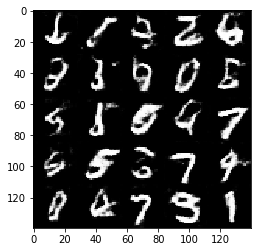

Epoch 1/2... Discriminator Loss: 1.4504... Generator Loss: 0.4704
Epoch 1/2... Discriminator Loss: 1.2739... Generator Loss: 0.7513
Epoch 1/2... Discriminator Loss: 1.1578... Generator Loss: 0.8737
Epoch 1/2... Discriminator Loss: 1.3518... Generator Loss: 1.1340
Epoch 1/2... Discriminator Loss: 1.3341... Generator Loss: 1.1867
Epoch 1/2... Discriminator Loss: 1.2835... Generator Loss: 1.1078
Epoch 1/2... Discriminator Loss: 1.2816... Generator Loss: 0.8913
Epoch 1/2... Discriminator Loss: 1.2632... Generator Loss: 0.9375
Epoch 1/2... Discriminator Loss: 1.3210... Generator Loss: 0.6487
Epoch 1/2... Discriminator Loss: 1.2897... Generator Loss: 0.6872


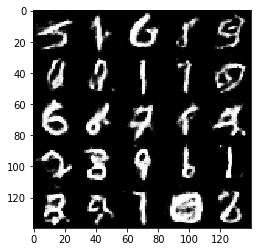

Epoch 1/2... Discriminator Loss: 1.3293... Generator Loss: 0.9217
Epoch 1/2... Discriminator Loss: 1.1988... Generator Loss: 0.8872
Epoch 1/2... Discriminator Loss: 1.2687... Generator Loss: 0.7320
Epoch 1/2... Discriminator Loss: 1.2737... Generator Loss: 1.2446
Epoch 1/2... Discriminator Loss: 1.1811... Generator Loss: 0.7766
Epoch 1/2... Discriminator Loss: 1.1131... Generator Loss: 1.0195
Epoch 1/2... Discriminator Loss: 1.3578... Generator Loss: 0.7293
Epoch 1/2... Discriminator Loss: 1.1940... Generator Loss: 0.9139
Epoch 1/2... Discriminator Loss: 1.3030... Generator Loss: 0.5747
Epoch 1/2... Discriminator Loss: 1.1811... Generator Loss: 0.9066


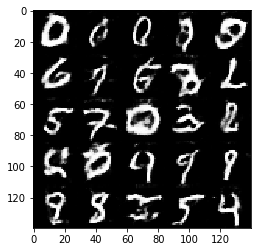

Epoch 1/2... Discriminator Loss: 1.2786... Generator Loss: 0.7476
Epoch 1/2... Discriminator Loss: 1.3330... Generator Loss: 0.5747
Epoch 1/2... Discriminator Loss: 1.2021... Generator Loss: 0.8906
Epoch 1/2... Discriminator Loss: 1.3683... Generator Loss: 0.7087
Epoch 1/2... Discriminator Loss: 1.3132... Generator Loss: 0.9145
Epoch 1/2... Discriminator Loss: 1.3040... Generator Loss: 1.1022
Epoch 1/2... Discriminator Loss: 1.0862... Generator Loss: 1.1264
Epoch 1/2... Discriminator Loss: 1.1977... Generator Loss: 1.0350
Epoch 1/2... Discriminator Loss: 1.3082... Generator Loss: 0.7182
Epoch 1/2... Discriminator Loss: 1.3383... Generator Loss: 0.5286


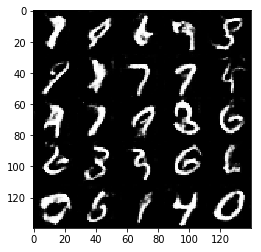

Epoch 1/2... Discriminator Loss: 1.2606... Generator Loss: 0.9119
Epoch 1/2... Discriminator Loss: 1.2803... Generator Loss: 0.8162
Epoch 1/2... Discriminator Loss: 1.4413... Generator Loss: 0.6298
Epoch 2/2... Discriminator Loss: 1.1614... Generator Loss: 0.6930
Epoch 2/2... Discriminator Loss: 1.2010... Generator Loss: 0.7115
Epoch 2/2... Discriminator Loss: 1.3933... Generator Loss: 0.8671
Epoch 2/2... Discriminator Loss: 1.2553... Generator Loss: 0.6059
Epoch 2/2... Discriminator Loss: 1.2577... Generator Loss: 0.5822
Epoch 2/2... Discriminator Loss: 1.1461... Generator Loss: 0.7002
Epoch 2/2... Discriminator Loss: 1.2115... Generator Loss: 0.9203


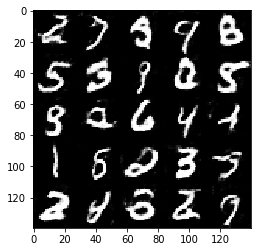

Epoch 2/2... Discriminator Loss: 1.2863... Generator Loss: 0.9523
Epoch 2/2... Discriminator Loss: 1.3527... Generator Loss: 0.7044
Epoch 2/2... Discriminator Loss: 1.3800... Generator Loss: 0.9205
Epoch 2/2... Discriminator Loss: 1.3463... Generator Loss: 0.9962
Epoch 2/2... Discriminator Loss: 1.2264... Generator Loss: 1.1459
Epoch 2/2... Discriminator Loss: 1.2461... Generator Loss: 0.7504
Epoch 2/2... Discriminator Loss: 1.2828... Generator Loss: 0.5803
Epoch 2/2... Discriminator Loss: 1.2526... Generator Loss: 0.7058
Epoch 2/2... Discriminator Loss: 1.2228... Generator Loss: 0.7953
Epoch 2/2... Discriminator Loss: 1.3763... Generator Loss: 0.5881


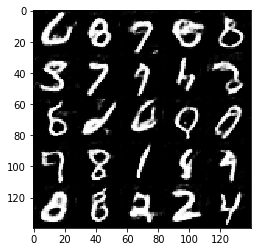

Epoch 2/2... Discriminator Loss: 1.2457... Generator Loss: 0.7319
Epoch 2/2... Discriminator Loss: 1.1872... Generator Loss: 0.8198
Epoch 2/2... Discriminator Loss: 1.2150... Generator Loss: 0.8663
Epoch 2/2... Discriminator Loss: 1.3622... Generator Loss: 0.5538
Epoch 2/2... Discriminator Loss: 1.2603... Generator Loss: 0.5528
Epoch 2/2... Discriminator Loss: 1.3048... Generator Loss: 0.5668
Epoch 2/2... Discriminator Loss: 1.2584... Generator Loss: 0.8307
Epoch 2/2... Discriminator Loss: 1.3108... Generator Loss: 0.8406
Epoch 2/2... Discriminator Loss: 1.2270... Generator Loss: 0.8590
Epoch 2/2... Discriminator Loss: 1.1804... Generator Loss: 0.7102


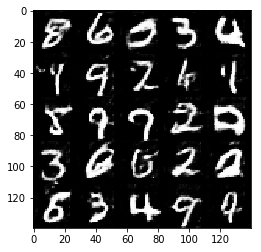

Epoch 2/2... Discriminator Loss: 1.3118... Generator Loss: 0.6522
Epoch 2/2... Discriminator Loss: 1.2336... Generator Loss: 0.6997
Epoch 2/2... Discriminator Loss: 1.1385... Generator Loss: 0.8536
Epoch 2/2... Discriminator Loss: 1.2007... Generator Loss: 0.7984
Epoch 2/2... Discriminator Loss: 1.5545... Generator Loss: 0.5252
Epoch 2/2... Discriminator Loss: 1.2573... Generator Loss: 0.6719
Epoch 2/2... Discriminator Loss: 1.1611... Generator Loss: 0.7439
Epoch 2/2... Discriminator Loss: 1.3309... Generator Loss: 0.5699
Epoch 2/2... Discriminator Loss: 1.1938... Generator Loss: 0.9690
Epoch 2/2... Discriminator Loss: 1.3078... Generator Loss: 0.6846


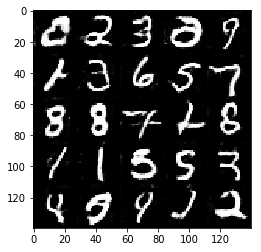

Epoch 2/2... Discriminator Loss: 1.3338... Generator Loss: 0.6562
Epoch 2/2... Discriminator Loss: 1.3452... Generator Loss: 0.8620
Epoch 2/2... Discriminator Loss: 1.2029... Generator Loss: 0.7830
Epoch 2/2... Discriminator Loss: 1.2317... Generator Loss: 0.8082
Epoch 2/2... Discriminator Loss: 1.1984... Generator Loss: 0.8240
Epoch 2/2... Discriminator Loss: 1.4574... Generator Loss: 0.7369
Epoch 2/2... Discriminator Loss: 1.4485... Generator Loss: 0.4483
Epoch 2/2... Discriminator Loss: 1.2838... Generator Loss: 0.8771
Epoch 2/2... Discriminator Loss: 1.1908... Generator Loss: 0.8015
Epoch 2/2... Discriminator Loss: 1.4102... Generator Loss: 0.7491


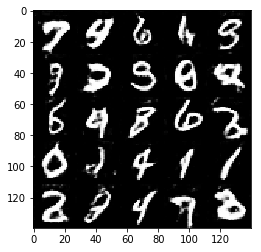

Epoch 2/2... Discriminator Loss: 1.1108... Generator Loss: 0.7262
Epoch 2/2... Discriminator Loss: 1.3158... Generator Loss: 0.8415
Epoch 2/2... Discriminator Loss: 1.2895... Generator Loss: 0.8537
Epoch 2/2... Discriminator Loss: 1.2997... Generator Loss: 1.0090
Epoch 2/2... Discriminator Loss: 1.2823... Generator Loss: 0.6227
Epoch 2/2... Discriminator Loss: 1.2363... Generator Loss: 0.7051
Epoch 2/2... Discriminator Loss: 1.2071... Generator Loss: 1.1811
Epoch 2/2... Discriminator Loss: 1.1837... Generator Loss: 0.6867
Epoch 2/2... Discriminator Loss: 1.1370... Generator Loss: 1.0946
Epoch 2/2... Discriminator Loss: 1.2420... Generator Loss: 0.7265


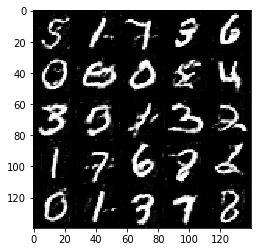

Epoch 2/2... Discriminator Loss: 1.1423... Generator Loss: 1.0282
Epoch 2/2... Discriminator Loss: 1.2272... Generator Loss: 0.8213
Epoch 2/2... Discriminator Loss: 1.3191... Generator Loss: 0.6533
Epoch 2/2... Discriminator Loss: 1.3452... Generator Loss: 0.4696
Epoch 2/2... Discriminator Loss: 1.0941... Generator Loss: 0.8483
Epoch 2/2... Discriminator Loss: 1.1919... Generator Loss: 0.9654
Epoch 2/2... Discriminator Loss: 1.3257... Generator Loss: 0.4853
Epoch 2/2... Discriminator Loss: 1.2698... Generator Loss: 0.9565
Epoch 2/2... Discriminator Loss: 1.3084... Generator Loss: 0.8836
Epoch 2/2... Discriminator Loss: 1.1055... Generator Loss: 1.0282


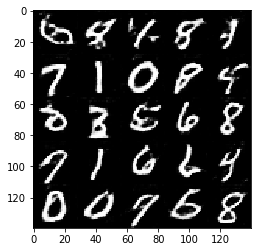

Epoch 2/2... Discriminator Loss: 1.2792... Generator Loss: 0.7202
Epoch 2/2... Discriminator Loss: 1.2878... Generator Loss: 0.8016
Epoch 2/2... Discriminator Loss: 1.1823... Generator Loss: 0.7702
Epoch 2/2... Discriminator Loss: 1.2777... Generator Loss: 0.6164
Epoch 2/2... Discriminator Loss: 1.2175... Generator Loss: 1.0242
Epoch 2/2... Discriminator Loss: 1.3823... Generator Loss: 0.5309
Epoch 2/2... Discriminator Loss: 1.1931... Generator Loss: 0.6395
Epoch 2/2... Discriminator Loss: 1.1958... Generator Loss: 0.9095
Epoch 2/2... Discriminator Loss: 1.1192... Generator Loss: 0.7912
Epoch 2/2... Discriminator Loss: 1.1610... Generator Loss: 1.1159


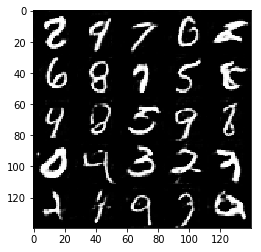

Epoch 2/2... Discriminator Loss: 1.2111... Generator Loss: 0.8333
Epoch 2/2... Discriminator Loss: 1.0343... Generator Loss: 0.9801
Epoch 2/2... Discriminator Loss: 1.4577... Generator Loss: 0.4720
Epoch 2/2... Discriminator Loss: 1.2263... Generator Loss: 0.7453
Epoch 2/2... Discriminator Loss: 1.1249... Generator Loss: 0.9597
Epoch 2/2... Discriminator Loss: 1.2005... Generator Loss: 0.8028
Epoch 2/2... Discriminator Loss: 1.1708... Generator Loss: 0.7345
Epoch 2/2... Discriminator Loss: 1.1694... Generator Loss: 0.8942
Epoch 2/2... Discriminator Loss: 1.1470... Generator Loss: 0.9346
Epoch 2/2... Discriminator Loss: 1.2012... Generator Loss: 0.7626


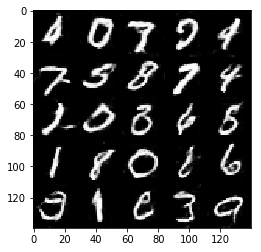

Epoch 2/2... Discriminator Loss: 1.2803... Generator Loss: 0.9848
Epoch 2/2... Discriminator Loss: 1.1205... Generator Loss: 0.8775
Epoch 2/2... Discriminator Loss: 1.1521... Generator Loss: 0.8675
Epoch 2/2... Discriminator Loss: 1.1262... Generator Loss: 0.8611
Epoch 2/2... Discriminator Loss: 1.1776... Generator Loss: 0.9064
Epoch 2/2... Discriminator Loss: 1.1755... Generator Loss: 0.9067
Epoch 2/2... Discriminator Loss: 1.4387... Generator Loss: 0.6962
Final Plot


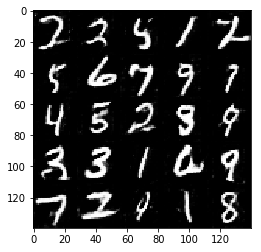

In [12]:
batch_size = 64
z_dim = 100
learning_rate = 0.001
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 0.3425... Generator Loss: 3.0039
Epoch 1/1... Discriminator Loss: 5.9068... Generator Loss: 0.0115
Epoch 1/1... Discriminator Loss: 1.5673... Generator Loss: 0.5924
Epoch 1/1... Discriminator Loss: 1.9032... Generator Loss: 0.4108
Epoch 1/1... Discriminator Loss: 0.6329... Generator Loss: 2.8648
Epoch 1/1... Discriminator Loss: 0.5274... Generator Loss: 1.3302
Epoch 1/1... Discriminator Loss: 1.2638... Generator Loss: 0.3952
Epoch 1/1... Discriminator Loss: 0.6860... Generator Loss: 1.4439
Epoch 1/1... Discriminator Loss: 1.1073... Generator Loss: 1.4263
Epoch 1/1... Discriminator Loss: 0.9440... Generator Loss: 1.6355


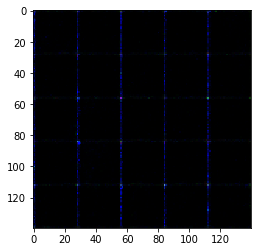

Epoch 1/1... Discriminator Loss: 1.8767... Generator Loss: 4.0491
Epoch 1/1... Discriminator Loss: 2.2476... Generator Loss: 0.1774
Epoch 1/1... Discriminator Loss: 1.4649... Generator Loss: 0.2827
Epoch 1/1... Discriminator Loss: 0.7775... Generator Loss: 1.2608
Epoch 1/1... Discriminator Loss: 1.1273... Generator Loss: 0.8412
Epoch 1/1... Discriminator Loss: 0.7826... Generator Loss: 1.3020
Epoch 1/1... Discriminator Loss: 0.8807... Generator Loss: 1.0508
Epoch 1/1... Discriminator Loss: 1.3418... Generator Loss: 0.5166
Epoch 1/1... Discriminator Loss: 1.4050... Generator Loss: 0.5095
Epoch 1/1... Discriminator Loss: 0.9136... Generator Loss: 1.7588


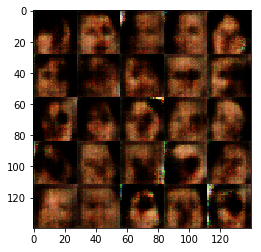

Epoch 1/1... Discriminator Loss: 1.3956... Generator Loss: 0.5116
Epoch 1/1... Discriminator Loss: 1.0452... Generator Loss: 1.4871
Epoch 1/1... Discriminator Loss: 1.4671... Generator Loss: 0.4621
Epoch 1/1... Discriminator Loss: 1.0172... Generator Loss: 1.1415
Epoch 1/1... Discriminator Loss: 1.7401... Generator Loss: 1.6541
Epoch 1/1... Discriminator Loss: 1.1083... Generator Loss: 1.3327
Epoch 1/1... Discriminator Loss: 1.1644... Generator Loss: 0.5799
Epoch 1/1... Discriminator Loss: 1.0227... Generator Loss: 1.2400
Epoch 1/1... Discriminator Loss: 1.4539... Generator Loss: 1.7846
Epoch 1/1... Discriminator Loss: 1.0814... Generator Loss: 1.0725


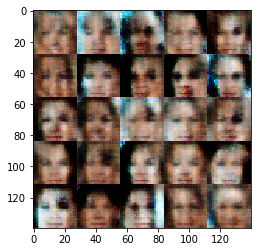

Epoch 1/1... Discriminator Loss: 0.8010... Generator Loss: 1.3949
Epoch 1/1... Discriminator Loss: 1.4357... Generator Loss: 0.6580
Epoch 1/1... Discriminator Loss: 1.0911... Generator Loss: 1.2434
Epoch 1/1... Discriminator Loss: 0.9167... Generator Loss: 1.3194
Epoch 1/1... Discriminator Loss: 1.7865... Generator Loss: 0.2409
Epoch 1/1... Discriminator Loss: 0.8642... Generator Loss: 1.1031
Epoch 1/1... Discriminator Loss: 1.4876... Generator Loss: 0.5005
Epoch 1/1... Discriminator Loss: 1.2740... Generator Loss: 0.5155
Epoch 1/1... Discriminator Loss: 1.8500... Generator Loss: 0.2040
Epoch 1/1... Discriminator Loss: 1.2433... Generator Loss: 0.6728


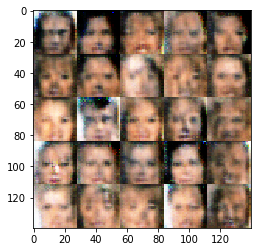

Epoch 1/1... Discriminator Loss: 1.4544... Generator Loss: 0.4897
Epoch 1/1... Discriminator Loss: 1.3622... Generator Loss: 0.6263
Epoch 1/1... Discriminator Loss: 1.4336... Generator Loss: 0.3816
Epoch 1/1... Discriminator Loss: 1.4588... Generator Loss: 0.4638
Epoch 1/1... Discriminator Loss: 1.5951... Generator Loss: 1.3404
Epoch 1/1... Discriminator Loss: 1.1136... Generator Loss: 0.7786
Epoch 1/1... Discriminator Loss: 1.2306... Generator Loss: 1.4162
Epoch 1/1... Discriminator Loss: 1.1324... Generator Loss: 1.0005
Epoch 1/1... Discriminator Loss: 1.6209... Generator Loss: 0.4583
Epoch 1/1... Discriminator Loss: 1.3186... Generator Loss: 0.6032


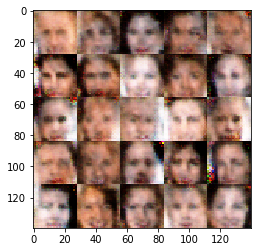

Epoch 1/1... Discriminator Loss: 1.2975... Generator Loss: 0.8453
Epoch 1/1... Discriminator Loss: 1.4305... Generator Loss: 0.5326
Epoch 1/1... Discriminator Loss: 1.5549... Generator Loss: 0.4476
Epoch 1/1... Discriminator Loss: 1.2233... Generator Loss: 1.2086
Epoch 1/1... Discriminator Loss: 1.0898... Generator Loss: 0.7311
Epoch 1/1... Discriminator Loss: 1.2505... Generator Loss: 0.5978
Epoch 1/1... Discriminator Loss: 1.4114... Generator Loss: 0.4913
Epoch 1/1... Discriminator Loss: 1.4506... Generator Loss: 0.3613
Epoch 1/1... Discriminator Loss: 1.4043... Generator Loss: 0.7349
Epoch 1/1... Discriminator Loss: 1.3754... Generator Loss: 0.5367


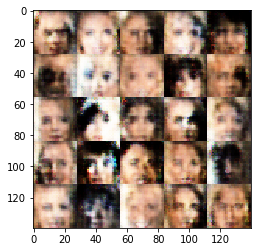

Epoch 1/1... Discriminator Loss: 1.2849... Generator Loss: 1.0099
Epoch 1/1... Discriminator Loss: 1.3760... Generator Loss: 0.6297
Epoch 1/1... Discriminator Loss: 1.3063... Generator Loss: 0.6658
Epoch 1/1... Discriminator Loss: 1.3259... Generator Loss: 0.6326
Epoch 1/1... Discriminator Loss: 1.4827... Generator Loss: 0.3888
Epoch 1/1... Discriminator Loss: 1.4211... Generator Loss: 0.6290
Epoch 1/1... Discriminator Loss: 1.1233... Generator Loss: 0.7045
Epoch 1/1... Discriminator Loss: 1.2481... Generator Loss: 1.1399
Epoch 1/1... Discriminator Loss: 1.4912... Generator Loss: 0.7201
Epoch 1/1... Discriminator Loss: 1.4724... Generator Loss: 0.9034


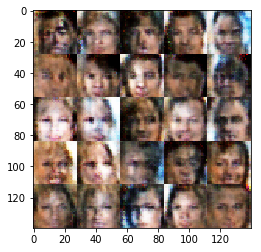

Epoch 1/1... Discriminator Loss: 1.3539... Generator Loss: 1.3205
Epoch 1/1... Discriminator Loss: 1.4073... Generator Loss: 0.6939
Epoch 1/1... Discriminator Loss: 1.2972... Generator Loss: 0.6698
Epoch 1/1... Discriminator Loss: 1.3262... Generator Loss: 0.9601
Epoch 1/1... Discriminator Loss: 1.5329... Generator Loss: 0.3936
Epoch 1/1... Discriminator Loss: 1.3621... Generator Loss: 0.6410
Epoch 1/1... Discriminator Loss: 1.2921... Generator Loss: 1.1045
Epoch 1/1... Discriminator Loss: 1.3788... Generator Loss: 0.8631
Epoch 1/1... Discriminator Loss: 1.4587... Generator Loss: 0.6174
Epoch 1/1... Discriminator Loss: 1.5190... Generator Loss: 0.5770


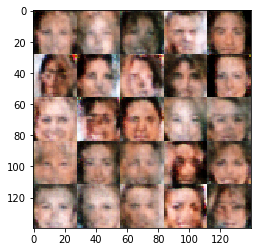

Epoch 1/1... Discriminator Loss: 1.5711... Generator Loss: 0.3666
Epoch 1/1... Discriminator Loss: 1.3403... Generator Loss: 0.9272
Epoch 1/1... Discriminator Loss: 1.4496... Generator Loss: 0.6472
Epoch 1/1... Discriminator Loss: 1.2294... Generator Loss: 0.9924
Epoch 1/1... Discriminator Loss: 1.2874... Generator Loss: 0.8403
Epoch 1/1... Discriminator Loss: 1.3402... Generator Loss: 0.6717
Epoch 1/1... Discriminator Loss: 1.3660... Generator Loss: 0.5937
Epoch 1/1... Discriminator Loss: 1.2479... Generator Loss: 0.7458
Epoch 1/1... Discriminator Loss: 1.4433... Generator Loss: 0.5937
Epoch 1/1... Discriminator Loss: 1.3732... Generator Loss: 0.6256


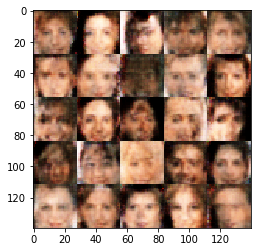

Epoch 1/1... Discriminator Loss: 1.2807... Generator Loss: 0.8013
Epoch 1/1... Discriminator Loss: 1.2380... Generator Loss: 0.7152
Epoch 1/1... Discriminator Loss: 1.3670... Generator Loss: 0.6812
Epoch 1/1... Discriminator Loss: 1.1925... Generator Loss: 0.8324
Epoch 1/1... Discriminator Loss: 1.1392... Generator Loss: 0.6276
Epoch 1/1... Discriminator Loss: 1.3273... Generator Loss: 0.8304
Epoch 1/1... Discriminator Loss: 1.6210... Generator Loss: 0.6109
Epoch 1/1... Discriminator Loss: 1.3383... Generator Loss: 0.6972
Epoch 1/1... Discriminator Loss: 1.2040... Generator Loss: 0.7741
Epoch 1/1... Discriminator Loss: 1.4882... Generator Loss: 0.5751


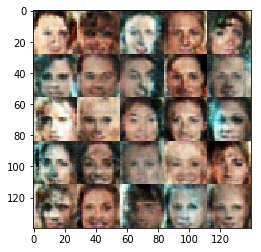

Epoch 1/1... Discriminator Loss: 1.4433... Generator Loss: 0.5906
Epoch 1/1... Discriminator Loss: 1.2857... Generator Loss: 0.5791
Epoch 1/1... Discriminator Loss: 1.3417... Generator Loss: 0.6915
Epoch 1/1... Discriminator Loss: 1.1953... Generator Loss: 0.7911
Epoch 1/1... Discriminator Loss: 1.1875... Generator Loss: 0.7932
Epoch 1/1... Discriminator Loss: 1.3883... Generator Loss: 0.6565
Epoch 1/1... Discriminator Loss: 1.2412... Generator Loss: 0.8137
Epoch 1/1... Discriminator Loss: 1.3177... Generator Loss: 0.7337
Epoch 1/1... Discriminator Loss: 1.3727... Generator Loss: 0.6397
Epoch 1/1... Discriminator Loss: 1.4447... Generator Loss: 0.6121


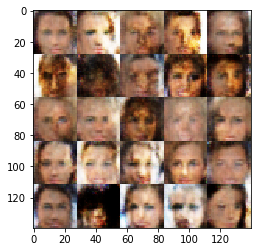

Epoch 1/1... Discriminator Loss: 1.3677... Generator Loss: 0.6726
Epoch 1/1... Discriminator Loss: 1.5041... Generator Loss: 0.7211
Epoch 1/1... Discriminator Loss: 1.3354... Generator Loss: 0.6413
Epoch 1/1... Discriminator Loss: 1.2575... Generator Loss: 0.7242
Epoch 1/1... Discriminator Loss: 1.5104... Generator Loss: 0.5293
Epoch 1/1... Discriminator Loss: 1.1712... Generator Loss: 0.8397
Epoch 1/1... Discriminator Loss: 1.2742... Generator Loss: 0.6872
Epoch 1/1... Discriminator Loss: 1.3474... Generator Loss: 0.7149
Epoch 1/1... Discriminator Loss: 1.2791... Generator Loss: 0.7541
Epoch 1/1... Discriminator Loss: 1.3263... Generator Loss: 0.6684


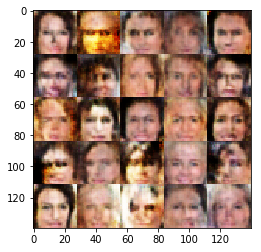

Epoch 1/1... Discriminator Loss: 1.4068... Generator Loss: 0.7342
Epoch 1/1... Discriminator Loss: 1.2716... Generator Loss: 0.6373
Epoch 1/1... Discriminator Loss: 1.5417... Generator Loss: 0.5597
Epoch 1/1... Discriminator Loss: 1.4415... Generator Loss: 0.6142
Epoch 1/1... Discriminator Loss: 1.7554... Generator Loss: 0.4510
Epoch 1/1... Discriminator Loss: 1.5798... Generator Loss: 0.5254
Epoch 1/1... Discriminator Loss: 1.5301... Generator Loss: 0.5040
Epoch 1/1... Discriminator Loss: 1.2668... Generator Loss: 0.6986
Epoch 1/1... Discriminator Loss: 1.3178... Generator Loss: 0.5848
Epoch 1/1... Discriminator Loss: 1.2902... Generator Loss: 0.6297


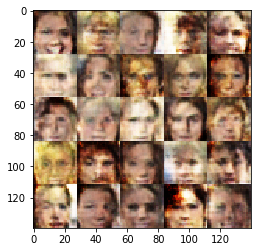

Epoch 1/1... Discriminator Loss: 1.3612... Generator Loss: 0.6603
Epoch 1/1... Discriminator Loss: 1.3979... Generator Loss: 0.6696
Epoch 1/1... Discriminator Loss: 1.4373... Generator Loss: 0.7425
Epoch 1/1... Discriminator Loss: 1.3233... Generator Loss: 0.6952
Epoch 1/1... Discriminator Loss: 1.3782... Generator Loss: 0.7802
Epoch 1/1... Discriminator Loss: 1.3463... Generator Loss: 0.6955
Epoch 1/1... Discriminator Loss: 1.5544... Generator Loss: 0.4425
Epoch 1/1... Discriminator Loss: 1.2425... Generator Loss: 0.9492
Epoch 1/1... Discriminator Loss: 1.3460... Generator Loss: 0.8223
Epoch 1/1... Discriminator Loss: 1.5318... Generator Loss: 0.5168


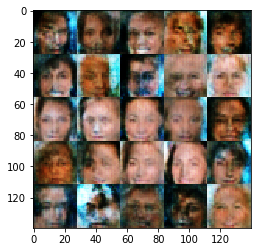

Epoch 1/1... Discriminator Loss: 1.2752... Generator Loss: 0.7336
Epoch 1/1... Discriminator Loss: 1.2472... Generator Loss: 0.6829
Epoch 1/1... Discriminator Loss: 1.4675... Generator Loss: 0.5835
Epoch 1/1... Discriminator Loss: 1.3818... Generator Loss: 0.6250
Epoch 1/1... Discriminator Loss: 1.5281... Generator Loss: 0.5470
Epoch 1/1... Discriminator Loss: 1.2800... Generator Loss: 0.7879
Epoch 1/1... Discriminator Loss: 1.3696... Generator Loss: 0.5977
Epoch 1/1... Discriminator Loss: 1.3210... Generator Loss: 0.6455
Epoch 1/1... Discriminator Loss: 1.3274... Generator Loss: 0.6936
Epoch 1/1... Discriminator Loss: 1.3686... Generator Loss: 0.5371


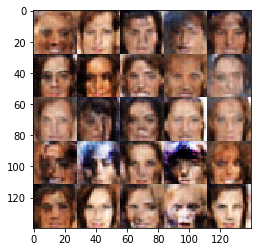

Epoch 1/1... Discriminator Loss: 1.3912... Generator Loss: 0.6658
Epoch 1/1... Discriminator Loss: 1.3927... Generator Loss: 0.6920
Epoch 1/1... Discriminator Loss: 1.4691... Generator Loss: 0.5361
Epoch 1/1... Discriminator Loss: 1.4800... Generator Loss: 0.5710
Epoch 1/1... Discriminator Loss: 1.4068... Generator Loss: 0.5911
Epoch 1/1... Discriminator Loss: 1.3263... Generator Loss: 0.7796
Epoch 1/1... Discriminator Loss: 1.4525... Generator Loss: 0.6049
Epoch 1/1... Discriminator Loss: 1.4052... Generator Loss: 0.6873
Epoch 1/1... Discriminator Loss: 1.3946... Generator Loss: 0.5897
Epoch 1/1... Discriminator Loss: 1.3940... Generator Loss: 0.6193


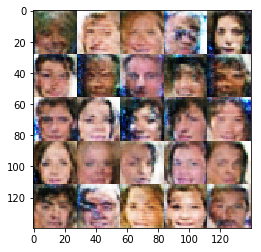

Epoch 1/1... Discriminator Loss: 1.3636... Generator Loss: 0.6989
Epoch 1/1... Discriminator Loss: 1.1722... Generator Loss: 0.8681
Epoch 1/1... Discriminator Loss: 1.4358... Generator Loss: 0.6227
Epoch 1/1... Discriminator Loss: 1.4289... Generator Loss: 0.6735
Epoch 1/1... Discriminator Loss: 1.4173... Generator Loss: 0.7543
Epoch 1/1... Discriminator Loss: 1.4030... Generator Loss: 0.6668
Epoch 1/1... Discriminator Loss: 1.3954... Generator Loss: 0.6434
Epoch 1/1... Discriminator Loss: 1.2973... Generator Loss: 0.8346
Epoch 1/1... Discriminator Loss: 1.4095... Generator Loss: 0.5223
Epoch 1/1... Discriminator Loss: 1.3029... Generator Loss: 0.6810


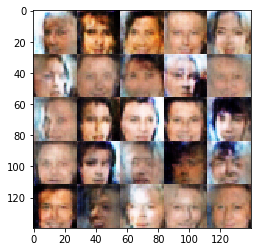

Epoch 1/1... Discriminator Loss: 1.3045... Generator Loss: 0.7652
Epoch 1/1... Discriminator Loss: 1.4810... Generator Loss: 0.7492
Epoch 1/1... Discriminator Loss: 1.2901... Generator Loss: 0.7591
Epoch 1/1... Discriminator Loss: 1.4421... Generator Loss: 0.6849
Epoch 1/1... Discriminator Loss: 1.4697... Generator Loss: 0.6951
Epoch 1/1... Discriminator Loss: 1.3162... Generator Loss: 0.6855
Epoch 1/1... Discriminator Loss: 1.3182... Generator Loss: 0.6980
Epoch 1/1... Discriminator Loss: 1.3518... Generator Loss: 0.6778
Epoch 1/1... Discriminator Loss: 1.3905... Generator Loss: 0.6986
Epoch 1/1... Discriminator Loss: 1.3804... Generator Loss: 0.6491


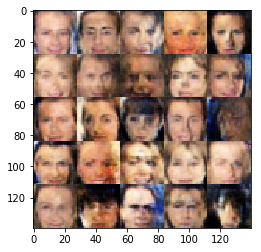

Epoch 1/1... Discriminator Loss: 1.3099... Generator Loss: 0.6972
Epoch 1/1... Discriminator Loss: 1.3603... Generator Loss: 0.7746
Epoch 1/1... Discriminator Loss: 1.3946... Generator Loss: 0.7395
Epoch 1/1... Discriminator Loss: 1.2373... Generator Loss: 0.6939
Epoch 1/1... Discriminator Loss: 1.3467... Generator Loss: 0.8029
Epoch 1/1... Discriminator Loss: 1.3740... Generator Loss: 0.6120
Epoch 1/1... Discriminator Loss: 1.3080... Generator Loss: 0.6342
Epoch 1/1... Discriminator Loss: 1.3511... Generator Loss: 0.6756
Epoch 1/1... Discriminator Loss: 1.4219... Generator Loss: 0.6365
Epoch 1/1... Discriminator Loss: 1.3917... Generator Loss: 0.6274


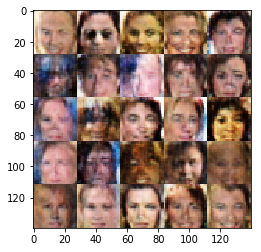

Epoch 1/1... Discriminator Loss: 1.2404... Generator Loss: 0.7085
Epoch 1/1... Discriminator Loss: 1.4887... Generator Loss: 0.6475
Epoch 1/1... Discriminator Loss: 1.5750... Generator Loss: 0.6054
Epoch 1/1... Discriminator Loss: 1.3277... Generator Loss: 0.6600
Epoch 1/1... Discriminator Loss: 1.3595... Generator Loss: 0.6105
Epoch 1/1... Discriminator Loss: 1.4390... Generator Loss: 0.5744
Epoch 1/1... Discriminator Loss: 1.3099... Generator Loss: 0.6900
Epoch 1/1... Discriminator Loss: 1.4118... Generator Loss: 0.6841
Epoch 1/1... Discriminator Loss: 1.4696... Generator Loss: 0.5858
Epoch 1/1... Discriminator Loss: 1.2482... Generator Loss: 0.7540


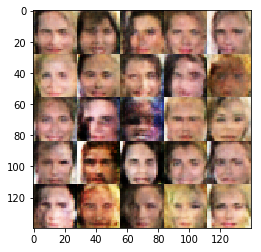

Epoch 1/1... Discriminator Loss: 1.2078... Generator Loss: 0.8267
Epoch 1/1... Discriminator Loss: 1.4777... Generator Loss: 0.6660
Epoch 1/1... Discriminator Loss: 1.4230... Generator Loss: 0.7327
Epoch 1/1... Discriminator Loss: 1.3166... Generator Loss: 0.6525
Epoch 1/1... Discriminator Loss: 1.3472... Generator Loss: 0.6122
Epoch 1/1... Discriminator Loss: 1.5008... Generator Loss: 0.6589
Epoch 1/1... Discriminator Loss: 1.4096... Generator Loss: 0.5347
Epoch 1/1... Discriminator Loss: 1.4104... Generator Loss: 0.6467
Epoch 1/1... Discriminator Loss: 1.3102... Generator Loss: 0.7578
Epoch 1/1... Discriminator Loss: 1.2929... Generator Loss: 0.7891


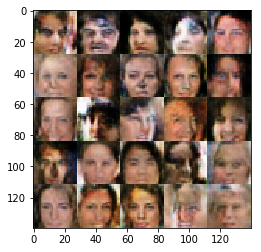

Epoch 1/1... Discriminator Loss: 1.4001... Generator Loss: 0.5820
Epoch 1/1... Discriminator Loss: 1.3612... Generator Loss: 0.6552
Epoch 1/1... Discriminator Loss: 1.3698... Generator Loss: 0.5706
Epoch 1/1... Discriminator Loss: 1.2829... Generator Loss: 0.6086
Epoch 1/1... Discriminator Loss: 1.4196... Generator Loss: 0.5991
Epoch 1/1... Discriminator Loss: 1.2738... Generator Loss: 0.7826
Epoch 1/1... Discriminator Loss: 1.2141... Generator Loss: 0.7612
Epoch 1/1... Discriminator Loss: 1.2995... Generator Loss: 0.6608
Epoch 1/1... Discriminator Loss: 1.4282... Generator Loss: 0.4951
Epoch 1/1... Discriminator Loss: 1.5360... Generator Loss: 0.6252


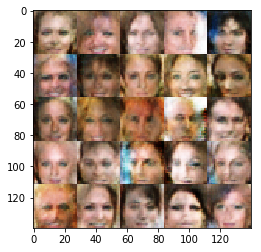

Epoch 1/1... Discriminator Loss: 1.2973... Generator Loss: 0.7371
Epoch 1/1... Discriminator Loss: 1.5919... Generator Loss: 0.6452
Epoch 1/1... Discriminator Loss: 1.3373... Generator Loss: 0.6360
Epoch 1/1... Discriminator Loss: 1.4356... Generator Loss: 0.6067
Epoch 1/1... Discriminator Loss: 1.3550... Generator Loss: 0.6985
Epoch 1/1... Discriminator Loss: 1.3791... Generator Loss: 0.7231
Epoch 1/1... Discriminator Loss: 1.4123... Generator Loss: 0.7007
Epoch 1/1... Discriminator Loss: 1.3721... Generator Loss: 0.6553
Epoch 1/1... Discriminator Loss: 1.3394... Generator Loss: 0.6585
Epoch 1/1... Discriminator Loss: 1.4304... Generator Loss: 0.6210


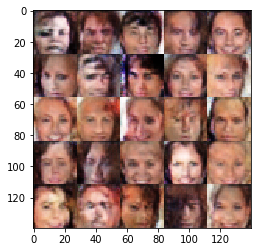

Epoch 1/1... Discriminator Loss: 1.3550... Generator Loss: 0.7493
Epoch 1/1... Discriminator Loss: 1.3286... Generator Loss: 0.6942
Epoch 1/1... Discriminator Loss: 1.4196... Generator Loss: 0.6533
Epoch 1/1... Discriminator Loss: 1.4136... Generator Loss: 0.5107
Epoch 1/1... Discriminator Loss: 1.3165... Generator Loss: 0.6088
Epoch 1/1... Discriminator Loss: 1.3658... Generator Loss: 0.7024
Epoch 1/1... Discriminator Loss: 1.3599... Generator Loss: 0.6432
Epoch 1/1... Discriminator Loss: 1.3275... Generator Loss: 0.6943
Epoch 1/1... Discriminator Loss: 1.4877... Generator Loss: 0.5533
Epoch 1/1... Discriminator Loss: 1.3610... Generator Loss: 0.6358


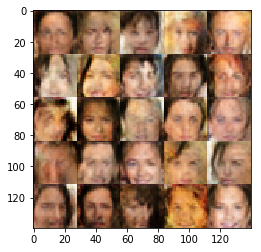

Epoch 1/1... Discriminator Loss: 1.4437... Generator Loss: 0.5594
Epoch 1/1... Discriminator Loss: 1.3522... Generator Loss: 0.5640
Epoch 1/1... Discriminator Loss: 1.4858... Generator Loss: 0.6521
Epoch 1/1... Discriminator Loss: 1.4886... Generator Loss: 0.5663
Epoch 1/1... Discriminator Loss: 1.5044... Generator Loss: 0.5744
Epoch 1/1... Discriminator Loss: 1.3761... Generator Loss: 0.6434
Epoch 1/1... Discriminator Loss: 1.3215... Generator Loss: 0.6263
Epoch 1/1... Discriminator Loss: 1.3831... Generator Loss: 0.7358
Epoch 1/1... Discriminator Loss: 1.3403... Generator Loss: 0.6774
Epoch 1/1... Discriminator Loss: 1.3337... Generator Loss: 0.7392


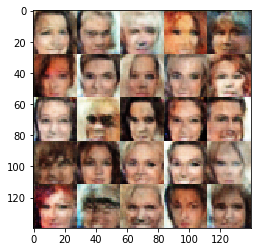

Epoch 1/1... Discriminator Loss: 1.4016... Generator Loss: 0.6231
Epoch 1/1... Discriminator Loss: 1.2859... Generator Loss: 0.6561
Epoch 1/1... Discriminator Loss: 1.3795... Generator Loss: 0.6895
Epoch 1/1... Discriminator Loss: 1.4107... Generator Loss: 0.6604
Epoch 1/1... Discriminator Loss: 1.4327... Generator Loss: 0.6516
Epoch 1/1... Discriminator Loss: 1.2186... Generator Loss: 0.7537
Epoch 1/1... Discriminator Loss: 1.4286... Generator Loss: 0.6276
Epoch 1/1... Discriminator Loss: 1.2740... Generator Loss: 0.7081
Epoch 1/1... Discriminator Loss: 1.4804... Generator Loss: 0.6168
Epoch 1/1... Discriminator Loss: 1.3745... Generator Loss: 0.6497


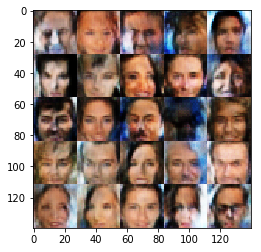

Epoch 1/1... Discriminator Loss: 1.3752... Generator Loss: 0.6524
Epoch 1/1... Discriminator Loss: 1.3943... Generator Loss: 0.6203
Epoch 1/1... Discriminator Loss: 1.2940... Generator Loss: 0.7480
Epoch 1/1... Discriminator Loss: 1.3297... Generator Loss: 0.6898
Epoch 1/1... Discriminator Loss: 1.3504... Generator Loss: 0.6740
Epoch 1/1... Discriminator Loss: 1.3564... Generator Loss: 0.6923
Epoch 1/1... Discriminator Loss: 1.4893... Generator Loss: 0.5331
Epoch 1/1... Discriminator Loss: 1.3632... Generator Loss: 0.6546
Epoch 1/1... Discriminator Loss: 1.3712... Generator Loss: 0.6474
Epoch 1/1... Discriminator Loss: 1.3324... Generator Loss: 0.7669


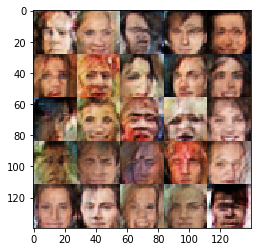

Epoch 1/1... Discriminator Loss: 1.3290... Generator Loss: 0.7032
Epoch 1/1... Discriminator Loss: 1.3959... Generator Loss: 0.5918
Epoch 1/1... Discriminator Loss: 1.3137... Generator Loss: 0.7594
Epoch 1/1... Discriminator Loss: 1.4262... Generator Loss: 0.6136
Epoch 1/1... Discriminator Loss: 1.4082... Generator Loss: 0.6234
Epoch 1/1... Discriminator Loss: 1.5494... Generator Loss: 0.5521
Epoch 1/1... Discriminator Loss: 1.4338... Generator Loss: 0.6892
Epoch 1/1... Discriminator Loss: 1.2924... Generator Loss: 0.7290
Epoch 1/1... Discriminator Loss: 1.2777... Generator Loss: 0.6739
Epoch 1/1... Discriminator Loss: 1.4069... Generator Loss: 0.5232


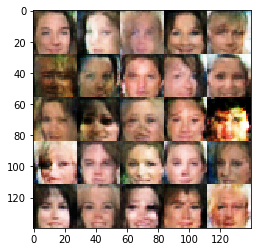

Epoch 1/1... Discriminator Loss: 1.3500... Generator Loss: 0.6304
Epoch 1/1... Discriminator Loss: 1.2795... Generator Loss: 0.7261
Epoch 1/1... Discriminator Loss: 1.5798... Generator Loss: 0.6332
Epoch 1/1... Discriminator Loss: 1.4208... Generator Loss: 0.6114
Epoch 1/1... Discriminator Loss: 1.4444... Generator Loss: 0.6255
Epoch 1/1... Discriminator Loss: 1.3144... Generator Loss: 0.7084
Epoch 1/1... Discriminator Loss: 1.3667... Generator Loss: 0.6545
Epoch 1/1... Discriminator Loss: 1.3136... Generator Loss: 0.7602
Epoch 1/1... Discriminator Loss: 1.4263... Generator Loss: 0.6360
Epoch 1/1... Discriminator Loss: 1.2956... Generator Loss: 0.6843


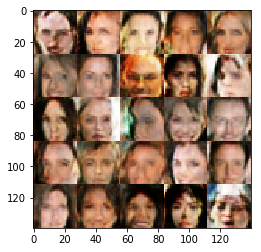

Epoch 1/1... Discriminator Loss: 1.3965... Generator Loss: 0.7276
Epoch 1/1... Discriminator Loss: 1.4468... Generator Loss: 0.6214
Epoch 1/1... Discriminator Loss: 1.3107... Generator Loss: 0.7205
Epoch 1/1... Discriminator Loss: 1.3513... Generator Loss: 0.7178
Epoch 1/1... Discriminator Loss: 1.3907... Generator Loss: 0.7386
Epoch 1/1... Discriminator Loss: 1.3811... Generator Loss: 0.6519
Epoch 1/1... Discriminator Loss: 1.3481... Generator Loss: 0.7575
Epoch 1/1... Discriminator Loss: 1.3753... Generator Loss: 0.6095
Epoch 1/1... Discriminator Loss: 1.2756... Generator Loss: 0.7734
Epoch 1/1... Discriminator Loss: 1.4864... Generator Loss: 0.7058


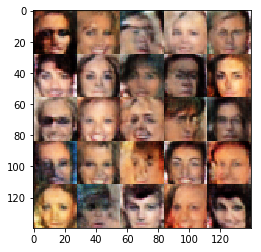

Epoch 1/1... Discriminator Loss: 1.4247... Generator Loss: 0.6337
Epoch 1/1... Discriminator Loss: 1.4345... Generator Loss: 0.7001
Epoch 1/1... Discriminator Loss: 1.1734... Generator Loss: 0.8103
Epoch 1/1... Discriminator Loss: 1.4173... Generator Loss: 0.6692
Epoch 1/1... Discriminator Loss: 1.3065... Generator Loss: 0.6877
Epoch 1/1... Discriminator Loss: 1.3704... Generator Loss: 0.6494
Epoch 1/1... Discriminator Loss: 1.4135... Generator Loss: 0.6093
Epoch 1/1... Discriminator Loss: 1.4029... Generator Loss: 0.7021
Epoch 1/1... Discriminator Loss: 1.2623... Generator Loss: 0.7787
Epoch 1/1... Discriminator Loss: 1.4552... Generator Loss: 0.6621


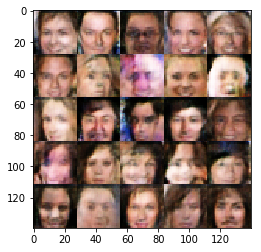

Epoch 1/1... Discriminator Loss: 1.3575... Generator Loss: 0.6881
Epoch 1/1... Discriminator Loss: 1.2750... Generator Loss: 0.6914
Epoch 1/1... Discriminator Loss: 1.5419... Generator Loss: 0.5371
Epoch 1/1... Discriminator Loss: 1.4752... Generator Loss: 0.5265
Epoch 1/1... Discriminator Loss: 1.1806... Generator Loss: 0.7759
Epoch 1/1... Discriminator Loss: 1.4203... Generator Loss: 0.6814
Epoch 1/1... Discriminator Loss: 1.4752... Generator Loss: 0.5632
Epoch 1/1... Discriminator Loss: 1.4111... Generator Loss: 0.6271
Epoch 1/1... Discriminator Loss: 1.3717... Generator Loss: 0.6536
Epoch 1/1... Discriminator Loss: 1.3100... Generator Loss: 0.7011


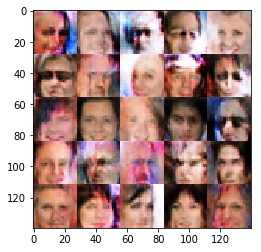

Epoch 1/1... Discriminator Loss: 1.4005... Generator Loss: 0.6501
Epoch 1/1... Discriminator Loss: 1.4016... Generator Loss: 0.7203
Epoch 1/1... Discriminator Loss: 1.2795... Generator Loss: 0.6830
Epoch 1/1... Discriminator Loss: 1.4618... Generator Loss: 0.6294
Epoch 1/1... Discriminator Loss: 1.3360... Generator Loss: 0.6753
Epoch 1/1... Discriminator Loss: 1.4059... Generator Loss: 0.6166
Epoch 1/1... Discriminator Loss: 1.3518... Generator Loss: 0.7312
Epoch 1/1... Discriminator Loss: 1.3332... Generator Loss: 0.6235
Epoch 1/1... Discriminator Loss: 1.4488... Generator Loss: 0.6588
Epoch 1/1... Discriminator Loss: 1.2805... Generator Loss: 0.7126


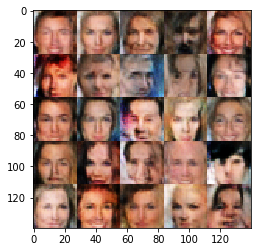

Epoch 1/1... Discriminator Loss: 1.3058... Generator Loss: 0.6427
Epoch 1/1... Discriminator Loss: 1.3977... Generator Loss: 0.6536
Epoch 1/1... Discriminator Loss: 1.3680... Generator Loss: 0.6536
Epoch 1/1... Discriminator Loss: 1.5494... Generator Loss: 0.6583
Epoch 1/1... Discriminator Loss: 1.4923... Generator Loss: 0.5881
Epoch 1/1... Discriminator Loss: 1.3733... Generator Loss: 0.6522
Epoch 1/1... Discriminator Loss: 1.2065... Generator Loss: 0.8105
Epoch 1/1... Discriminator Loss: 1.4853... Generator Loss: 0.6181
Epoch 1/1... Discriminator Loss: 1.4185... Generator Loss: 0.6174
Epoch 1/1... Discriminator Loss: 1.3160... Generator Loss: 0.6172


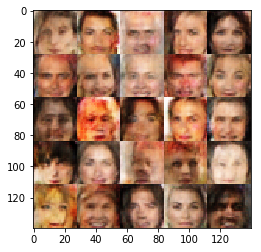

Epoch 1/1... Discriminator Loss: 1.3689... Generator Loss: 0.6476
Epoch 1/1... Discriminator Loss: 1.3968... Generator Loss: 0.6776
Epoch 1/1... Discriminator Loss: 1.3902... Generator Loss: 0.6519
Epoch 1/1... Discriminator Loss: 1.4436... Generator Loss: 0.7019
Epoch 1/1... Discriminator Loss: 1.3212... Generator Loss: 0.6176
Epoch 1/1... Discriminator Loss: 1.3313... Generator Loss: 0.7118
Epoch 1/1... Discriminator Loss: 1.4145... Generator Loss: 0.6410
Epoch 1/1... Discriminator Loss: 1.4133... Generator Loss: 0.5869
Epoch 1/1... Discriminator Loss: 1.4036... Generator Loss: 0.7121
Epoch 1/1... Discriminator Loss: 1.4210... Generator Loss: 0.6151


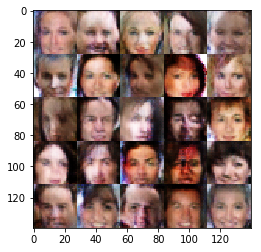

Epoch 1/1... Discriminator Loss: 1.3521... Generator Loss: 0.7048
Epoch 1/1... Discriminator Loss: 1.4664... Generator Loss: 0.7438
Epoch 1/1... Discriminator Loss: 1.4243... Generator Loss: 0.6888
Epoch 1/1... Discriminator Loss: 1.4404... Generator Loss: 0.6190
Epoch 1/1... Discriminator Loss: 1.3344... Generator Loss: 0.6144
Epoch 1/1... Discriminator Loss: 1.3491... Generator Loss: 0.7003
Epoch 1/1... Discriminator Loss: 1.4323... Generator Loss: 0.7526
Epoch 1/1... Discriminator Loss: 1.4769... Generator Loss: 0.6169
Epoch 1/1... Discriminator Loss: 1.3384... Generator Loss: 0.6603
Epoch 1/1... Discriminator Loss: 1.3953... Generator Loss: 0.6674


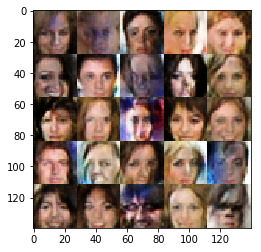

Epoch 1/1... Discriminator Loss: 1.2610... Generator Loss: 0.7451
Epoch 1/1... Discriminator Loss: 1.2834... Generator Loss: 0.7440
Epoch 1/1... Discriminator Loss: 1.3784... Generator Loss: 0.5819
Epoch 1/1... Discriminator Loss: 1.3022... Generator Loss: 0.7066
Epoch 1/1... Discriminator Loss: 1.3658... Generator Loss: 0.7395
Epoch 1/1... Discriminator Loss: 1.2952... Generator Loss: 0.7429
Epoch 1/1... Discriminator Loss: 1.3174... Generator Loss: 0.7239
Epoch 1/1... Discriminator Loss: 1.3905... Generator Loss: 0.6932
Epoch 1/1... Discriminator Loss: 1.3824... Generator Loss: 0.6267
Epoch 1/1... Discriminator Loss: 1.2422... Generator Loss: 0.7315


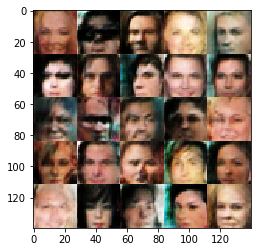

Epoch 1/1... Discriminator Loss: 1.3301... Generator Loss: 0.6540
Epoch 1/1... Discriminator Loss: 1.3677... Generator Loss: 0.6768
Epoch 1/1... Discriminator Loss: 1.4158... Generator Loss: 0.5835
Epoch 1/1... Discriminator Loss: 1.3697... Generator Loss: 0.6405
Epoch 1/1... Discriminator Loss: 1.3924... Generator Loss: 0.6899
Epoch 1/1... Discriminator Loss: 1.3284... Generator Loss: 0.6776
Epoch 1/1... Discriminator Loss: 1.3516... Generator Loss: 0.7244
Epoch 1/1... Discriminator Loss: 1.3818... Generator Loss: 0.6805
Epoch 1/1... Discriminator Loss: 1.4591... Generator Loss: 0.7341
Epoch 1/1... Discriminator Loss: 1.3667... Generator Loss: 0.7054


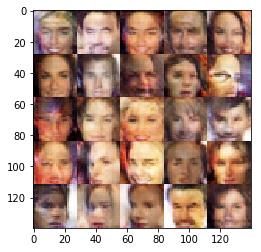

Epoch 1/1... Discriminator Loss: 1.3206... Generator Loss: 0.6826
Epoch 1/1... Discriminator Loss: 1.4101... Generator Loss: 0.7103
Epoch 1/1... Discriminator Loss: 1.4401... Generator Loss: 0.6556
Epoch 1/1... Discriminator Loss: 1.4372... Generator Loss: 0.6164
Epoch 1/1... Discriminator Loss: 1.3528... Generator Loss: 0.6554
Epoch 1/1... Discriminator Loss: 1.3880... Generator Loss: 0.6988
Epoch 1/1... Discriminator Loss: 1.2965... Generator Loss: 0.7301
Epoch 1/1... Discriminator Loss: 1.3695... Generator Loss: 0.6424
Epoch 1/1... Discriminator Loss: 1.3266... Generator Loss: 0.6935
Epoch 1/1... Discriminator Loss: 1.3341... Generator Loss: 0.8193


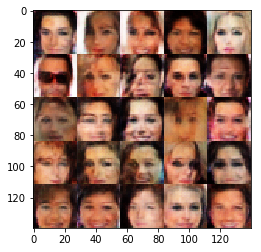

Epoch 1/1... Discriminator Loss: 1.4120... Generator Loss: 0.5883
Epoch 1/1... Discriminator Loss: 1.3428... Generator Loss: 0.7395
Epoch 1/1... Discriminator Loss: 1.3851... Generator Loss: 0.6786
Epoch 1/1... Discriminator Loss: 1.5216... Generator Loss: 0.6102
Epoch 1/1... Discriminator Loss: 1.4491... Generator Loss: 0.6020
Epoch 1/1... Discriminator Loss: 1.3565... Generator Loss: 0.7149
Epoch 1/1... Discriminator Loss: 1.3702... Generator Loss: 0.7149
Epoch 1/1... Discriminator Loss: 1.3065... Generator Loss: 0.7510
Epoch 1/1... Discriminator Loss: 1.3179... Generator Loss: 0.6574
Epoch 1/1... Discriminator Loss: 1.3609... Generator Loss: 0.7320


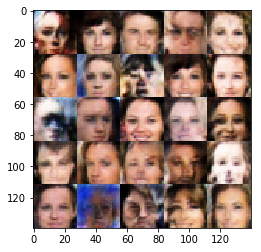

Epoch 1/1... Discriminator Loss: 1.4376... Generator Loss: 0.6661
Epoch 1/1... Discriminator Loss: 1.4124... Generator Loss: 0.5962
Epoch 1/1... Discriminator Loss: 1.3877... Generator Loss: 0.6787
Epoch 1/1... Discriminator Loss: 1.3692... Generator Loss: 0.6992
Epoch 1/1... Discriminator Loss: 1.2519... Generator Loss: 0.6727
Epoch 1/1... Discriminator Loss: 1.3671... Generator Loss: 0.6534
Epoch 1/1... Discriminator Loss: 1.2946... Generator Loss: 0.6827
Epoch 1/1... Discriminator Loss: 1.4242... Generator Loss: 0.5929
Epoch 1/1... Discriminator Loss: 1.4416... Generator Loss: 0.6793
Epoch 1/1... Discriminator Loss: 1.3983... Generator Loss: 0.6605


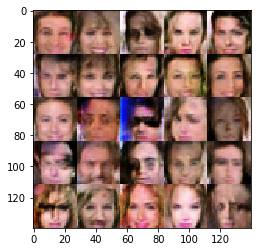

Epoch 1/1... Discriminator Loss: 1.4241... Generator Loss: 0.6020
Epoch 1/1... Discriminator Loss: 1.3649... Generator Loss: 0.7304
Epoch 1/1... Discriminator Loss: 1.4166... Generator Loss: 0.6296
Epoch 1/1... Discriminator Loss: 1.2951... Generator Loss: 0.7456
Epoch 1/1... Discriminator Loss: 1.3571... Generator Loss: 0.7246
Epoch 1/1... Discriminator Loss: 1.4270... Generator Loss: 0.6601
Epoch 1/1... Discriminator Loss: 1.3613... Generator Loss: 0.6785
Epoch 1/1... Discriminator Loss: 1.3319... Generator Loss: 0.6855
Epoch 1/1... Discriminator Loss: 1.3629... Generator Loss: 0.6732
Epoch 1/1... Discriminator Loss: 1.4191... Generator Loss: 0.6793


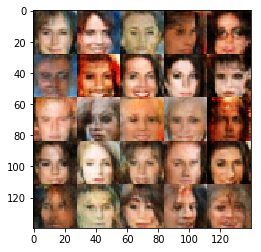

Epoch 1/1... Discriminator Loss: 1.4390... Generator Loss: 0.6225
Epoch 1/1... Discriminator Loss: 1.3664... Generator Loss: 0.7139
Epoch 1/1... Discriminator Loss: 1.3968... Generator Loss: 0.6635
Epoch 1/1... Discriminator Loss: 1.3230... Generator Loss: 0.6434
Epoch 1/1... Discriminator Loss: 1.3259... Generator Loss: 0.6705
Epoch 1/1... Discriminator Loss: 1.4186... Generator Loss: 0.7065
Epoch 1/1... Discriminator Loss: 1.3460... Generator Loss: 0.7225
Epoch 1/1... Discriminator Loss: 1.4213... Generator Loss: 0.6829
Epoch 1/1... Discriminator Loss: 1.3684... Generator Loss: 0.6579
Epoch 1/1... Discriminator Loss: 1.4495... Generator Loss: 0.6859


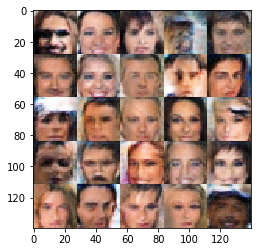

Epoch 1/1... Discriminator Loss: 1.3068... Generator Loss: 0.7222
Epoch 1/1... Discriminator Loss: 1.2763... Generator Loss: 0.7494
Epoch 1/1... Discriminator Loss: 1.3648... Generator Loss: 0.7327
Epoch 1/1... Discriminator Loss: 1.3723... Generator Loss: 0.6661
Epoch 1/1... Discriminator Loss: 1.3719... Generator Loss: 0.6583
Epoch 1/1... Discriminator Loss: 1.3849... Generator Loss: 0.6913
Epoch 1/1... Discriminator Loss: 1.3144... Generator Loss: 0.7008
Epoch 1/1... Discriminator Loss: 1.4207... Generator Loss: 0.6382
Epoch 1/1... Discriminator Loss: 1.3317... Generator Loss: 0.6626
Epoch 1/1... Discriminator Loss: 1.3834... Generator Loss: 0.6815


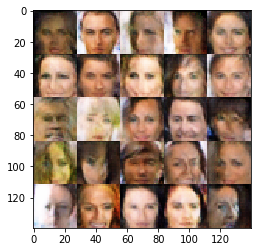

Epoch 1/1... Discriminator Loss: 1.4545... Generator Loss: 0.6418
Epoch 1/1... Discriminator Loss: 1.3115... Generator Loss: 0.7134
Epoch 1/1... Discriminator Loss: 1.4751... Generator Loss: 0.6156
Epoch 1/1... Discriminator Loss: 1.3451... Generator Loss: 0.7139
Epoch 1/1... Discriminator Loss: 1.4044... Generator Loss: 0.6636
Epoch 1/1... Discriminator Loss: 1.4063... Generator Loss: 0.6842
Epoch 1/1... Discriminator Loss: 1.4217... Generator Loss: 0.6476
Epoch 1/1... Discriminator Loss: 1.3589... Generator Loss: 0.6204
Epoch 1/1... Discriminator Loss: 1.4190... Generator Loss: 0.6906
Epoch 1/1... Discriminator Loss: 1.3771... Generator Loss: 0.6547


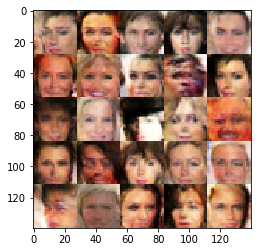

Epoch 1/1... Discriminator Loss: 1.3598... Generator Loss: 0.6572
Epoch 1/1... Discriminator Loss: 1.3284... Generator Loss: 0.6788
Epoch 1/1... Discriminator Loss: 1.4397... Generator Loss: 0.6230
Epoch 1/1... Discriminator Loss: 1.3647... Generator Loss: 0.6576
Epoch 1/1... Discriminator Loss: 1.3772... Generator Loss: 0.6084
Epoch 1/1... Discriminator Loss: 1.3537... Generator Loss: 0.6431
Epoch 1/1... Discriminator Loss: 1.4202... Generator Loss: 0.7040
Epoch 1/1... Discriminator Loss: 1.4813... Generator Loss: 0.7228
Epoch 1/1... Discriminator Loss: 1.3248... Generator Loss: 0.7121
Epoch 1/1... Discriminator Loss: 1.3526... Generator Loss: 0.6887


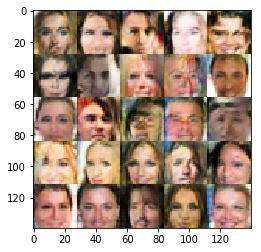

Epoch 1/1... Discriminator Loss: 1.4208... Generator Loss: 0.6995
Epoch 1/1... Discriminator Loss: 1.2660... Generator Loss: 0.7120
Epoch 1/1... Discriminator Loss: 1.3982... Generator Loss: 0.6962
Epoch 1/1... Discriminator Loss: 1.3693... Generator Loss: 0.7026
Epoch 1/1... Discriminator Loss: 1.3120... Generator Loss: 0.6954
Epoch 1/1... Discriminator Loss: 1.4063... Generator Loss: 0.6690
Epoch 1/1... Discriminator Loss: 1.3584... Generator Loss: 0.6976
Epoch 1/1... Discriminator Loss: 1.3382... Generator Loss: 0.6790
Epoch 1/1... Discriminator Loss: 1.3600... Generator Loss: 0.6926
Epoch 1/1... Discriminator Loss: 1.3661... Generator Loss: 0.6177


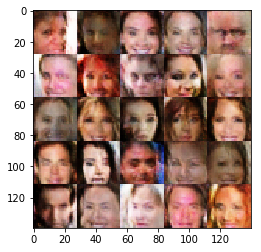

Epoch 1/1... Discriminator Loss: 1.4685... Generator Loss: 0.6386
Epoch 1/1... Discriminator Loss: 1.3235... Generator Loss: 0.7654
Epoch 1/1... Discriminator Loss: 1.3484... Generator Loss: 0.7036
Epoch 1/1... Discriminator Loss: 1.4556... Generator Loss: 0.6364
Epoch 1/1... Discriminator Loss: 1.3503... Generator Loss: 0.7088
Epoch 1/1... Discriminator Loss: 1.3663... Generator Loss: 0.7377
Epoch 1/1... Discriminator Loss: 1.4890... Generator Loss: 0.7121
Epoch 1/1... Discriminator Loss: 1.4492... Generator Loss: 0.6178
Epoch 1/1... Discriminator Loss: 1.3848... Generator Loss: 0.6565
Epoch 1/1... Discriminator Loss: 1.4902... Generator Loss: 0.5882


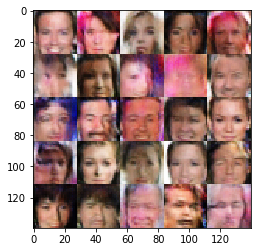

Epoch 1/1... Discriminator Loss: 1.4436... Generator Loss: 0.6547
Epoch 1/1... Discriminator Loss: 1.3562... Generator Loss: 0.6063
Epoch 1/1... Discriminator Loss: 1.3295... Generator Loss: 0.6268
Epoch 1/1... Discriminator Loss: 1.5059... Generator Loss: 0.6505
Epoch 1/1... Discriminator Loss: 1.2848... Generator Loss: 0.7243
Epoch 1/1... Discriminator Loss: 1.3378... Generator Loss: 0.7019
Epoch 1/1... Discriminator Loss: 1.3411... Generator Loss: 0.6920
Epoch 1/1... Discriminator Loss: 1.4229... Generator Loss: 0.6781
Epoch 1/1... Discriminator Loss: 1.3605... Generator Loss: 0.7507
Epoch 1/1... Discriminator Loss: 1.4142... Generator Loss: 0.7152


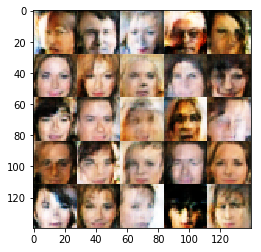

Epoch 1/1... Discriminator Loss: 1.3410... Generator Loss: 0.6652
Epoch 1/1... Discriminator Loss: 1.3525... Generator Loss: 0.7006
Epoch 1/1... Discriminator Loss: 1.3849... Generator Loss: 0.6199
Epoch 1/1... Discriminator Loss: 1.4070... Generator Loss: 0.6238
Epoch 1/1... Discriminator Loss: 1.3968... Generator Loss: 0.5815
Epoch 1/1... Discriminator Loss: 1.4422... Generator Loss: 0.6251
Epoch 1/1... Discriminator Loss: 1.4079... Generator Loss: 0.6622
Epoch 1/1... Discriminator Loss: 1.4270... Generator Loss: 0.6547
Epoch 1/1... Discriminator Loss: 1.3913... Generator Loss: 0.6318
Epoch 1/1... Discriminator Loss: 1.4325... Generator Loss: 0.5642


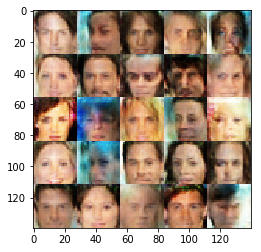

Epoch 1/1... Discriminator Loss: 1.4158... Generator Loss: 0.6957
Epoch 1/1... Discriminator Loss: 1.3667... Generator Loss: 0.7149
Epoch 1/1... Discriminator Loss: 1.4326... Generator Loss: 0.6200
Epoch 1/1... Discriminator Loss: 1.3584... Generator Loss: 0.6474
Epoch 1/1... Discriminator Loss: 1.3073... Generator Loss: 0.7255
Epoch 1/1... Discriminator Loss: 1.3049... Generator Loss: 0.6715
Epoch 1/1... Discriminator Loss: 1.3692... Generator Loss: 0.6341
Epoch 1/1... Discriminator Loss: 1.3738... Generator Loss: 0.7032
Epoch 1/1... Discriminator Loss: 1.4225... Generator Loss: 0.6512
Epoch 1/1... Discriminator Loss: 1.4116... Generator Loss: 0.6801


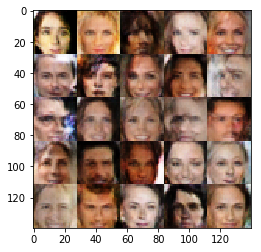

Epoch 1/1... Discriminator Loss: 1.4003... Generator Loss: 0.7054
Epoch 1/1... Discriminator Loss: 1.3189... Generator Loss: 0.6999
Epoch 1/1... Discriminator Loss: 1.3738... Generator Loss: 0.7509
Epoch 1/1... Discriminator Loss: 1.4104... Generator Loss: 0.6119
Epoch 1/1... Discriminator Loss: 1.3401... Generator Loss: 0.7126
Epoch 1/1... Discriminator Loss: 1.3686... Generator Loss: 0.6819
Epoch 1/1... Discriminator Loss: 1.3676... Generator Loss: 0.6915
Epoch 1/1... Discriminator Loss: 1.4911... Generator Loss: 0.6179
Epoch 1/1... Discriminator Loss: 1.4318... Generator Loss: 0.6234
Epoch 1/1... Discriminator Loss: 1.3986... Generator Loss: 0.6878


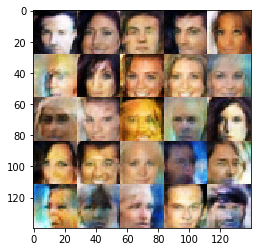

Epoch 1/1... Discriminator Loss: 1.4585... Generator Loss: 0.6830
Epoch 1/1... Discriminator Loss: 1.3999... Generator Loss: 0.6718
Epoch 1/1... Discriminator Loss: 1.3416... Generator Loss: 0.6688
Epoch 1/1... Discriminator Loss: 1.4404... Generator Loss: 0.6439
Epoch 1/1... Discriminator Loss: 1.3208... Generator Loss: 0.7769
Epoch 1/1... Discriminator Loss: 1.4129... Generator Loss: 0.6680
Epoch 1/1... Discriminator Loss: 1.3062... Generator Loss: 0.7293
Epoch 1/1... Discriminator Loss: 1.3268... Generator Loss: 0.7816
Epoch 1/1... Discriminator Loss: 1.4000... Generator Loss: 0.6239
Epoch 1/1... Discriminator Loss: 1.3477... Generator Loss: 0.6856


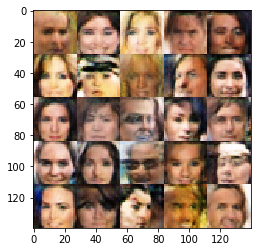

Epoch 1/1... Discriminator Loss: 1.3748... Generator Loss: 0.7456
Epoch 1/1... Discriminator Loss: 1.4294... Generator Loss: 0.6480
Epoch 1/1... Discriminator Loss: 1.3718... Generator Loss: 0.7012
Epoch 1/1... Discriminator Loss: 1.2836... Generator Loss: 0.7098
Epoch 1/1... Discriminator Loss: 1.3579... Generator Loss: 0.6324
Epoch 1/1... Discriminator Loss: 1.4421... Generator Loss: 0.6062
Epoch 1/1... Discriminator Loss: 1.4183... Generator Loss: 0.6200
Epoch 1/1... Discriminator Loss: 1.4103... Generator Loss: 0.6401
Epoch 1/1... Discriminator Loss: 1.3383... Generator Loss: 0.6914
Epoch 1/1... Discriminator Loss: 1.4444... Generator Loss: 0.6539


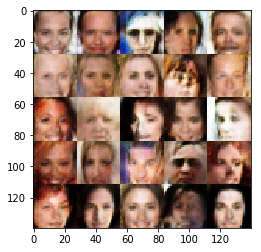

Epoch 1/1... Discriminator Loss: 1.3248... Generator Loss: 0.7083
Epoch 1/1... Discriminator Loss: 1.3467... Generator Loss: 0.6611
Epoch 1/1... Discriminator Loss: 1.3422... Generator Loss: 0.6899
Epoch 1/1... Discriminator Loss: 1.3112... Generator Loss: 0.7237
Epoch 1/1... Discriminator Loss: 1.4615... Generator Loss: 0.6104
Epoch 1/1... Discriminator Loss: 1.3720... Generator Loss: 0.6113
Epoch 1/1... Discriminator Loss: 1.3453... Generator Loss: 0.7652
Epoch 1/1... Discriminator Loss: 1.4074... Generator Loss: 0.5751
Epoch 1/1... Discriminator Loss: 1.4212... Generator Loss: 0.6194
Epoch 1/1... Discriminator Loss: 1.4309... Generator Loss: 0.6162


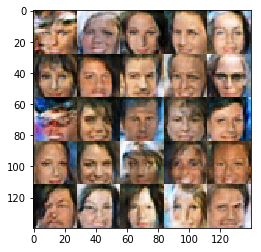

Epoch 1/1... Discriminator Loss: 1.3448... Generator Loss: 0.7222
Epoch 1/1... Discriminator Loss: 1.4284... Generator Loss: 0.5821
Epoch 1/1... Discriminator Loss: 1.3516... Generator Loss: 0.7330
Epoch 1/1... Discriminator Loss: 1.3866... Generator Loss: 0.6927
Epoch 1/1... Discriminator Loss: 1.3512... Generator Loss: 0.7261
Epoch 1/1... Discriminator Loss: 1.3485... Generator Loss: 0.7189
Epoch 1/1... Discriminator Loss: 1.3576... Generator Loss: 0.7065
Epoch 1/1... Discriminator Loss: 1.4689... Generator Loss: 0.6094
Epoch 1/1... Discriminator Loss: 1.3701... Generator Loss: 0.6814
Epoch 1/1... Discriminator Loss: 1.3299... Generator Loss: 0.7098


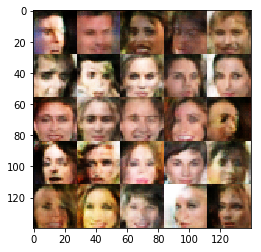

Epoch 1/1... Discriminator Loss: 1.4356... Generator Loss: 0.6562
Epoch 1/1... Discriminator Loss: 1.4038... Generator Loss: 0.6988
Epoch 1/1... Discriminator Loss: 1.3659... Generator Loss: 0.7270
Epoch 1/1... Discriminator Loss: 1.3597... Generator Loss: 0.7115
Epoch 1/1... Discriminator Loss: 1.4348... Generator Loss: 0.6820
Epoch 1/1... Discriminator Loss: 1.4178... Generator Loss: 0.6508
Epoch 1/1... Discriminator Loss: 1.4129... Generator Loss: 0.6234
Epoch 1/1... Discriminator Loss: 1.3338... Generator Loss: 0.7024
Epoch 1/1... Discriminator Loss: 1.3493... Generator Loss: 0.6458
Epoch 1/1... Discriminator Loss: 1.4411... Generator Loss: 0.5950


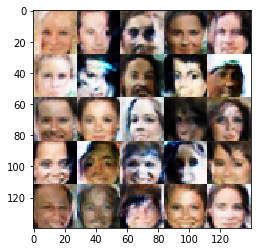

Epoch 1/1... Discriminator Loss: 1.4126... Generator Loss: 0.6482
Epoch 1/1... Discriminator Loss: 1.3243... Generator Loss: 0.7120
Epoch 1/1... Discriminator Loss: 1.3340... Generator Loss: 0.6244
Epoch 1/1... Discriminator Loss: 1.3230... Generator Loss: 0.7026
Epoch 1/1... Discriminator Loss: 1.2900... Generator Loss: 0.7089
Epoch 1/1... Discriminator Loss: 1.4601... Generator Loss: 0.7205
Epoch 1/1... Discriminator Loss: 1.4231... Generator Loss: 0.6439
Epoch 1/1... Discriminator Loss: 1.3890... Generator Loss: 0.6687
Epoch 1/1... Discriminator Loss: 1.4729... Generator Loss: 0.6909
Epoch 1/1... Discriminator Loss: 1.3828... Generator Loss: 0.6661


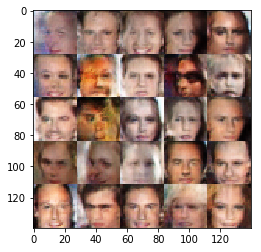

Epoch 1/1... Discriminator Loss: 1.3908... Generator Loss: 0.6254
Epoch 1/1... Discriminator Loss: 1.3672... Generator Loss: 0.7080
Epoch 1/1... Discriminator Loss: 1.3802... Generator Loss: 0.6822
Epoch 1/1... Discriminator Loss: 1.3493... Generator Loss: 0.7029
Epoch 1/1... Discriminator Loss: 1.4442... Generator Loss: 0.6466
Epoch 1/1... Discriminator Loss: 1.4405... Generator Loss: 0.6325
Epoch 1/1... Discriminator Loss: 1.4066... Generator Loss: 0.6496
Epoch 1/1... Discriminator Loss: 1.3079... Generator Loss: 0.6873
Epoch 1/1... Discriminator Loss: 1.3534... Generator Loss: 0.6178
Epoch 1/1... Discriminator Loss: 1.4452... Generator Loss: 0.6255


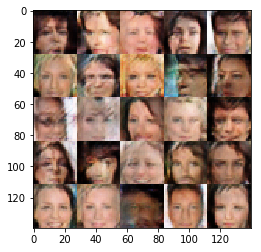

Epoch 1/1... Discriminator Loss: 1.4059... Generator Loss: 0.6916
Epoch 1/1... Discriminator Loss: 1.3200... Generator Loss: 0.6470
Epoch 1/1... Discriminator Loss: 1.3561... Generator Loss: 0.6906
Epoch 1/1... Discriminator Loss: 1.4484... Generator Loss: 0.6117
Epoch 1/1... Discriminator Loss: 1.4270... Generator Loss: 0.6814
Epoch 1/1... Discriminator Loss: 1.3736... Generator Loss: 0.6547
Epoch 1/1... Discriminator Loss: 1.4693... Generator Loss: 0.6237
Epoch 1/1... Discriminator Loss: 1.4033... Generator Loss: 0.6485
Epoch 1/1... Discriminator Loss: 1.3917... Generator Loss: 0.6551
Epoch 1/1... Discriminator Loss: 1.3253... Generator Loss: 0.7095


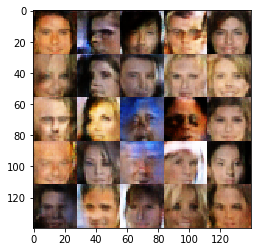

Epoch 1/1... Discriminator Loss: 1.4077... Generator Loss: 0.6301
Epoch 1/1... Discriminator Loss: 1.3409... Generator Loss: 0.6911
Epoch 1/1... Discriminator Loss: 1.4594... Generator Loss: 0.6590
Epoch 1/1... Discriminator Loss: 1.4097... Generator Loss: 0.6437
Epoch 1/1... Discriminator Loss: 1.3592... Generator Loss: 0.6778
Epoch 1/1... Discriminator Loss: 1.3773... Generator Loss: 0.6657
Epoch 1/1... Discriminator Loss: 1.3460... Generator Loss: 0.6944
Epoch 1/1... Discriminator Loss: 1.4964... Generator Loss: 0.5942
Epoch 1/1... Discriminator Loss: 1.2989... Generator Loss: 0.6831
Epoch 1/1... Discriminator Loss: 1.3588... Generator Loss: 0.7415


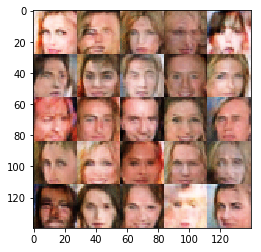

Epoch 1/1... Discriminator Loss: 1.3993... Generator Loss: 0.6139
Epoch 1/1... Discriminator Loss: 1.3532... Generator Loss: 0.6870
Epoch 1/1... Discriminator Loss: 1.3590... Generator Loss: 0.7191
Epoch 1/1... Discriminator Loss: 1.4090... Generator Loss: 0.6606
Epoch 1/1... Discriminator Loss: 1.3607... Generator Loss: 0.6738
Epoch 1/1... Discriminator Loss: 1.3693... Generator Loss: 0.7136
Epoch 1/1... Discriminator Loss: 1.4078... Generator Loss: 0.7268
Epoch 1/1... Discriminator Loss: 1.3274... Generator Loss: 0.7055
Epoch 1/1... Discriminator Loss: 1.3618... Generator Loss: 0.6643
Epoch 1/1... Discriminator Loss: 1.3982... Generator Loss: 0.6730


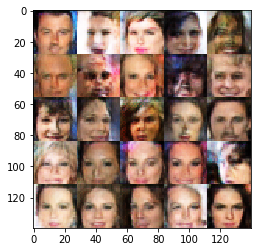

Epoch 1/1... Discriminator Loss: 1.3297... Generator Loss: 0.7052
Epoch 1/1... Discriminator Loss: 1.3426... Generator Loss: 0.7146
Epoch 1/1... Discriminator Loss: 1.3523... Generator Loss: 0.6567
Epoch 1/1... Discriminator Loss: 1.3304... Generator Loss: 0.7109
Epoch 1/1... Discriminator Loss: 1.4288... Generator Loss: 0.6645
Epoch 1/1... Discriminator Loss: 1.3687... Generator Loss: 0.6539
Epoch 1/1... Discriminator Loss: 1.3696... Generator Loss: 0.7074
Epoch 1/1... Discriminator Loss: 1.3927... Generator Loss: 0.6287
Epoch 1/1... Discriminator Loss: 1.3461... Generator Loss: 0.6839
Epoch 1/1... Discriminator Loss: 1.4072... Generator Loss: 0.6816


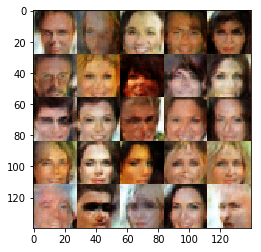

Epoch 1/1... Discriminator Loss: 1.2677... Generator Loss: 0.7445
Epoch 1/1... Discriminator Loss: 1.4167... Generator Loss: 0.6795
Epoch 1/1... Discriminator Loss: 1.4076... Generator Loss: 0.7333
Final Plot


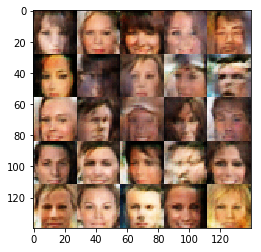

In [13]:
batch_size = 32
z_dim = 100
learning_rate = 0.0007
beta1 = 0.4


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.